# Training a Classifier using PyTorch

In this project, we will use the CIFAR10 dataset

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

### Loading train and test set

Since the PILImage is not normalized for direct training, let's create a transformation using `Compose`

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)


In [4]:
trainset = torchvision.datasets.CIFAR10(root='.data', train=True, download=False, transform=transform)
testset = torchvision.datasets.CIFAR10(root='.data', transform=transform, train=False, download=False)

In [5]:
print(trainset.data.shape)
print(testset.data.shape)
print(trainset.class_to_idx)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


Now, let's create a DataLoader to maintain efficiency in computation

In [6]:
def load_dataset(batch_size = 4):
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    return trainloader, testloader

batch_size = 5
trainloader, testloader = load_dataset(batch_size)

### Let's view some images

In [7]:
import matplotlib.pyplot as plt
import numpy as np

In [8]:
def imshow(img):
    img = img / 0.5 + 0.5     # Since, we normalized let's reverse it
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5..2.5].


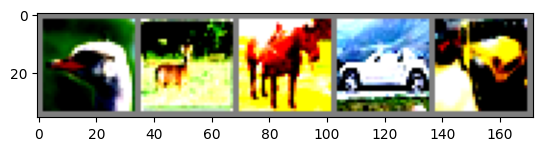

In [9]:
data = iter(trainloader)
images, labels = next(data)
imshow(torchvision.utils.make_grid(images))

### Let's create the CNN Model

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DynamicCNN(nn.Module):
    def __init__(self, conv_layers, conv_channels, fc_layers, fc_units, dropout_rate = 0.5, num_classes=10):
        super(DynamicCNN, self).__init__()

        self.conv_layers = conv_layers
        self.conv_channels = conv_channels
        self.fc_layers = fc_layers
        self.fc_units = fc_units
        self.dropout_rate = dropout_rate

        self.conv_blocks = self.build_conv_blocks()

        self.fc_blocks = self.build_fc_blocks(num_classes)

    def build_conv_blocks(self):
        layers = []
        in_channels = 3
        
        for i in range(self.conv_layers):
            out_channels = self.conv_channels[i]
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.MaxPool2d(2, 2))
            layers.append(nn.Dropout(self.dropout_rate))
            in_channels = out_channels
        
        return nn.Sequential(*layers)

    def build_fc_blocks(self, num_classes):
        layers = []
        
        # Flatten the output from convolutional layers, assuming input size of 32x32
        conv_output_size = 32 // (2 ** self.conv_layers) 
        fc_input_size = self.conv_channels[-1] * conv_output_size * conv_output_size
        
        in_features = fc_input_size
        for i in range(self.fc_layers):
            out_features = self.fc_units[i]
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(self.dropout_rate))
            in_features = out_features
        
        layers.append(nn.Linear(in_features, num_classes))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv_blocks(x)
        x = torch.flatten(x, 1)
        x = self.fc_blocks(x)
        return x

conv_layers = 3
conv_channels = [32, 64, 128]
fc_layers = 2 
fc_units = [128, 64]
dropout_rate = 0.5

net = DynamicCNN(conv_layers, conv_channels, fc_layers, fc_units, dropout_rate)

### Defining our loss

In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()


### Training our model

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# net.to(device)

cuda:0


In [13]:
def train_model(trainloader, net, epochs, learning_rate=0.001, momentum=0.9, weight_decay=0.0001):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net.to(device)

    optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)

    for epoch in range(epochs):
        running_loss = 0.0
        sets = 0
        itr = 0
        for i, data in enumerate(trainloader, 0):
            # Loads input & labels of dims = batch_size
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            if torch.isnan(loss):
                print(f"NaN loss encountered at epoch {epoch+1}, iteration {i+1}")
                return net

            optimizer.step()

            running_loss += loss.item()
            itr = i+1
        
        print(f'Epoch: {epoch + 1} loss: {running_loss / (itr):.3f}')

    print('XXXXXXXX Finished Training XXXXXXXXX')

    return net


In [14]:
net = train_model(trainloader, net, epochs=1)

Epoch: 1 loss: 1.856
XXXXXXXX Finished Training XXXXXXXXX


### Testing

In [15]:
classes = trainset.classes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5..2.5].


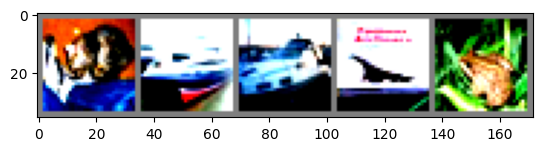

GroundTruth:  cat   ship  ship  airplane frog 


In [16]:
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [27]:
conv_layers = 3
conv_channels = [32, 64, 128]
fc_layers = 3 
fc_units = [128, 64, 32]
dropout_rate = 0.5

net = DynamicCNN(conv_layers, conv_channels, fc_layers, fc_units, dropout_rate)
PATH = 'cifar_net.pth'
net.load_state_dict(torch.load(PATH, weights_only=True))
net.to(device)

DynamicCNN(
  (conv_blocks): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.5, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.5, inplace=False)
  )
  (fc_blocks): Sequential(
    (0): Line

In [18]:

def test_accuracy(testloader, net):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net.to(device)
    correct = 0
    total = 0

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100 * correct // total

    return accuracy

accuracy_score = test_accuracy(testloader, net)
accuracy_score

37

In [ ]:

def test_individual_class_accuracy():
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # again no gradients needed
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

test_individual_class_accuracy()

We can see that for the default hyperparameters, the accuracy of the model is pretty bad. Let's try to optimize our model.

## Hyper-parameter Tuning

Hyperparameters we wanna modify:
- batch_size
- epochs
- learning_rate
- layers



Good resource on hyper parameter benchmarks, [here](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130)

Let's do K-fold Cross Validation to ensure our data isn't skewed during training

In [39]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Subset

def average_model_weights(models):
    avg_model = models[0]
    for key in avg_model.state_dict().keys():
        avg_model.state_dict()[key] = torch.mean(torch.stack([model.state_dict()[key].float() for model in models]), dim=0)
    return avg_model

def kfold_cross_validation(trainset, model, batch_size, epochs, learning_rate, momentum, weight_decay=0.0005, k=3):
    fold_size = len(trainset) // k
    models = []

    for fold in range(k):
        print(f'\n------------ FOLD {fold + 1} --------------')
        valid_start = fold * fold_size
        valid_end = valid_start + fold_size

        # Ensure indices are within the valid range
        if valid_end > len(trainset):
            valid_end = len(trainset)

        valid_indices = list(range(valid_start, valid_end))
        train_indices = list(range(0, valid_start)) + list(range(valid_end, len(trainset)))

        valid_subset = Subset(trainset, valid_indices)
        train_subset = Subset(trainset, train_indices)

        trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        validloader = DataLoader(valid_subset, batch_size=batch_size, shuffle=False)

        print('Created validation set')
        print('Created train set')

        print('\nXXXXXXXX Beginning model training XXXXXXXXXX')
        model = train_model(trainloader, model, epochs, learning_rate, momentum, weight_decay)

        print('\nXXXXXXX Testing the model XXXXXX')
        train_accuracy = test_accuracy(trainloader, model)
        print(f'Accuracy of the network on the train set: {train_accuracy} %')
        valid_accuracy = test_accuracy(validloader, model)
        print(f'Accuracy of the network on the validation set: {valid_accuracy} %')

        models.append(model)

    # Average the weights of all models
    avg_model = average_model_weights(models)

    # Test the averaged model
    print('\nXXXXXXX Testing the averaged model XXXXXX')
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    final_accuracy = test_accuracy(trainloader, avg_model)
    print(f'Accuracy of the averaged model on the entire training set: {final_accuracy} %')

    return avg_model, final_accuracy

# kfold_cross_validation(trainset, net, 4, 1, 0.001, 0.9)


### Model Layers

In [24]:
conv_layers = [1, 2, 3, 4]
conv_channels = [[32], [32, 64], [32, 64, 128], [32, 64, 128, 256]]
fc_layers = [1, 2, 3, 4] 
fc_units = [[128], [128, 64], [128, 64, 32], [128, 64, 32, 18]]
dropout_rate = 0.5
best_accuracy = float('inf')
best_model = None

In [ ]:


print('\n-------- Identifying optimal layers ---------')
itr = 4
layers = [i for i in range(1, itr+1)]
layer_acc = []

for i in range(itr):
    print(f'Trying layers: {i+1}')
    net = DynamicCNN(conv_layers[i], conv_channels[i], fc_layers[i], fc_units[i], dropout_rate)
    model, accuracy = kfold_cross_validation(trainset, net, 7, 8, 0.00088, 0.9)
    layer_acc.append(accuracy)

    if accuracy > best_accuracy:
        best_model = model
        best_accuracy = accuracy

    del net




-------- Identifying optimal layers ---------

------------ FOLD 1 --------------
Created validation set
Created train set

XXXXXXXX Beginning model training XXXXXXXXXX
Epoch: 1 loss: 1.717
Epoch: 2 loss: 1.464
Epoch: 3 loss: 1.313
Epoch: 4 loss: 1.218
Epoch: 5 loss: 1.162
Epoch: 6 loss: 1.126
Epoch: 7 loss: 1.092
Epoch: 8 loss: 1.062
XXXXXXXX Finished Training XXXXXXXXX

XXXXXXX Testing the model XXXXXX
Accuracy of the network on the train set: 64 %
Accuracy of the network on the validation set: 56 %

------------ FOLD 2 --------------
Created validation set
Created train set

XXXXXXXX Beginning model training XXXXXXXXXX
Epoch: 1 loss: 1.104
Epoch: 2 loss: 1.069
Epoch: 3 loss: 1.038
Epoch: 4 loss: 1.013
Epoch: 5 loss: 0.993
Epoch: 6 loss: 0.977
Epoch: 7 loss: 0.964
Epoch: 8 loss: 0.957
XXXXXXXX Finished Training XXXXXXXXX

XXXXXXX Testing the model XXXXXX
Accuracy of the network on the train set: 67 %
Accuracy of the network on the validation set: 60 %

------------ FOLD 3 ----------

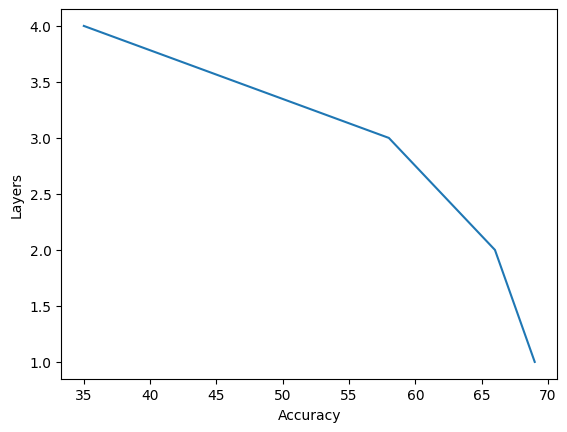

In [27]:
import matplotlib.pyplot as plt

plt.plot(layer_acc, layers)
plt.xlabel('Accuracy')
plt.ylabel('Layers')
plt.show()

The accuracy might be higher when the number of layers are less but I see that the difference between the train and validation accuracy is very similar in the case of having 3 layers. Therefore, I'm guessing training it on more epochs with 3 layers should give us a better solution. Let's try...

In [25]:
# best_layers = layer_acc.index(max(layer_acc))
best_layers = 2
opt_conv_layers = best_layers + 1
opt_conv_channels = conv_channels[best_layers]
opt_fc_layers = fc_layers[best_layers]
opt_fc_units = fc_units[best_layers]
dropout_rate = 0.5

In [26]:
print(opt_conv_layers)
print(opt_conv_channels)
print(opt_fc_layers)
print(opt_fc_units)

3
[32, 64, 128]
3
[128, 64, 32]


### Learning rate

In [44]:
# NOTE: Intially kept the end as 0.1 but encounterted loss nan problem (loss too high)
# Hence, reducing the end value to the good observed learning rate.
lr_start, lr_end = 0.0005, 0.001
best_accuracy = float('-inf')
best_model = None
best_lr = -1
lr_tuning_factor = 0.00001
learning_rates = []
lr_accuracies = []

print('\n-------- Identifying the best learning rate using Binary Search ---------')
max_itr = 4
itr = 1

while lr_start <= lr_end and itr <= max_itr:
    lr_mid = (lr_start + lr_end) / 2

    print(f'Trying learning rate: {lr_start}')
    net = DynamicCNN(opt_conv_layers, opt_conv_channels, opt_fc_layers, opt_fc_units, dropout_rate)
    start_model, start_accuracy = kfold_cross_validation(trainset, net, 7, 3, lr_start, 0.9)

    print(f'Trying learning rate: {lr_mid}')
    net = DynamicCNN(opt_conv_layers, opt_conv_channels, opt_fc_layers, opt_fc_units, dropout_rate)
    mid_model, mid_accuracy = kfold_cross_validation(trainset, net, 7, 3, lr_mid, 0.9)

    print(f'Trying learning rate: {lr_end}')
    net = DynamicCNN(opt_conv_layers, opt_conv_channels, opt_fc_layers, opt_fc_units, dropout_rate)
    end_model, end_accuracy = kfold_cross_validation(trainset, net, 7, 3, lr_end, 0.9)

    learning_rates.append([lr_start, lr_mid, lr_end])
    lr_accuracies.append([start_accuracy, mid_accuracy, end_accuracy])

    if start_accuracy > best_accuracy:
        best_accuracy = start_accuracy
        best_model = start_model
        best_lr = lr_start

    if mid_accuracy > best_accuracy:
        best_accuracy = mid_accuracy
        best_model = mid_model
        best_lr = lr_mid

    if end_accuracy > best_accuracy:
        best_accuracy = end_accuracy
        best_model = end_model
        best_lr = lr_end

    if start_accuracy > end_accuracy:
        lr_end = lr_mid - lr_tuning_factor
    else:
        lr_start = lr_mid + lr_tuning_factor

    itr += 1


-------- Identifying the best learning rate using Binary Search ---------
Trying learning rate: 0.0005

------------ FOLD 1 --------------
Created validation set
Created train set

XXXXXXXX Beginning model training XXXXXXXXXX
Epoch: 1 loss: 1.982
Epoch: 2 loss: 1.750
Epoch: 3 loss: 1.643
XXXXXXXX Finished Training XXXXXXXXX

XXXXXXX Testing the model XXXXXX
Accuracy of the network on the train set: 40 %
Accuracy of the network on the validation set: 40 %

------------ FOLD 2 --------------
Created validation set
Created train set

XXXXXXXX Beginning model training XXXXXXXXXX
Epoch: 1 loss: 1.585
Epoch: 2 loss: 1.541
Epoch: 3 loss: 1.500
XXXXXXXX Finished Training XXXXXXXXX

XXXXXXX Testing the model XXXXXX
Accuracy of the network on the train set: 46 %
Accuracy of the network on the validation set: 45 %

------------ FOLD 3 --------------
Created validation set
Created train set

XXXXXXXX Beginning model training XXXXXXXXXX
Epoch: 1 loss: 1.480
Epoch: 2 loss: 1.442
Epoch: 3 loss: 1.42

In [ ]:
def save_to_file(filename, **kwargs):
    with open(filename, 'a') as f:
        for var_name, values in kwargs.items():
            f.write(f'{var_name}\n')
            for value in values:
                f.write(f'{value}\n')
            f.write('\n')

# save_to_file('trained_hyperparameters.txt', lr_accuracies=lr_accuracies, learning_rates=learning_rates)

In [ ]:
sorted_pairs = sorted(zip(learning_rates, lr_accuracies))
learning_rates, lr_accuracies = zip(*sorted_pairs)

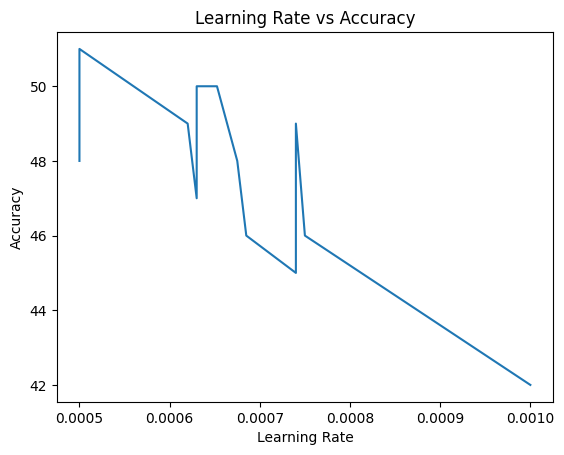

In [ ]:
import matplotlib.pyplot as plt

plt.plot(learning_rates, lr_accuracies)
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Learning Rate vs Accuracy')
plt.show()

In [47]:
# best_lr = 0.0013224999999999999
# best_lr = 0.00088
print(f'Found the best learning rate as: {best_lr}')

Found the best learning rate as: 0.0005


### Momentum

In [82]:
momentum_values = [0.25, 0.45, 0.60, 0.75, 0.90]
best_accuracy = float('-inf')
best_model = None
best_momentum = -1
momentum_accuracies = []

print('\n-------- Identifying the best momentum ---------')
for momentum in momentum_values:
    print(f'Trying momentum: {momentum}')
    net = DynamicCNN(opt_conv_layers, opt_conv_channels, opt_fc_layers, opt_fc_units, dropout_rate)
    model, accuracy = kfold_cross_validation(trainset, net, batch_size, 3, best_lr, momentum)
    momentum_accuracies.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_momentum = momentum


-------- Identifying the best momentum ---------
Trying momentum: 0.25

------------ FOLD 1 --------------
Created validation set
Created train set

XXXXXXXX Beginning model training XXXXXXXXXX
Epoch: 1 loss: 2.222
Epoch: 2 loss: 1.900
Epoch: 3 loss: 1.680
XXXXXXXX Finished Training XXXXXXXXX

XXXXXXX Testing the model XXXXXX
Accuracy of the network on the train set: 41 %
Accuracy of the network on the validation set: 41 %

------------ FOLD 2 --------------
Created validation set
Created train set

XXXXXXXX Beginning model training XXXXXXXXXX
Epoch: 1 loss: 1.561
Epoch: 2 loss: 1.474
Epoch: 3 loss: 1.400
XXXXXXXX Finished Training XXXXXXXXX

XXXXXXX Testing the model XXXXXX
Accuracy of the network on the train set: 51 %
Accuracy of the network on the validation set: 51 %

------------ FOLD 3 --------------
Created validation set
Created train set

XXXXXXXX Beginning model training XXXXXXXXXX
Epoch: 1 loss: 1.341
Epoch: 2 loss: 1.283
Epoch: 3 loss: 1.235
XXXXXXXX Finished Training XXX

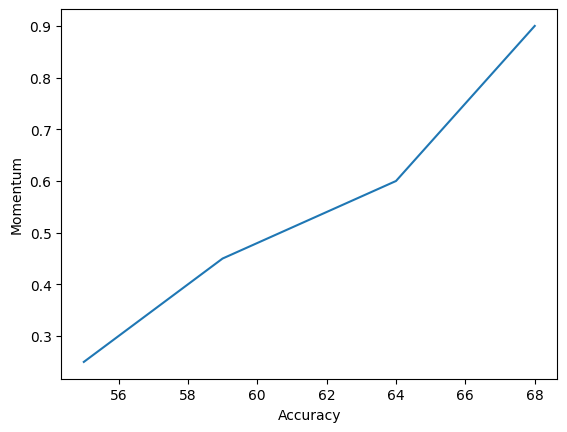

In [ ]:
import matplotlib.pyplot as plt

plt.plot(momentum_accuracies, momentum_values)
plt.xlabel('Accuracy')
plt.ylabel('Momentum')
plt.show()

In [90]:

save_to_file('trained_hyperparameters.txt', momentum_accuracies=momentum_accuracies, momentum_values=momentum_values)

In [48]:
best_momentum = 0.9
print(f'Found the best momentum as: {best_momentum}')

Found the best momentum as: 0.9


#### Batch Size

The accuracy was very poor when I tested the model on a `batch_size` of 15 initially. Hence, trying values under 10.

In [86]:
batch_sizes = [8, 24, 46, 98, 128]
best_accuracy = float('-inf')
best_model = None
best_batch_size = -1
batch_accuracies = []

print('\n-------- Identifying the best batch size ---------')
for batch_size in batch_sizes:
    print(f'Trying batch_size: {batch_size}')
    net = DynamicCNN(opt_conv_layers, opt_conv_channels, opt_fc_layers, opt_fc_units, dropout_rate)
    model, accuracy = kfold_cross_validation(trainset, net, batch_size, 10, best_lr, best_momentum)
    batch_accuracies.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_batch_size = batch_size


-------- Identifying the best batch size ---------
Trying batch_size: 4

------------ FOLD 1 --------------
Created validation set
Created train set

XXXXXXXX Beginning model training XXXXXXXXXX
Epoch: 1 loss: 1.770
Epoch: 2 loss: 1.391
Epoch: 3 loss: 1.263
XXXXXXXX Finished Training XXXXXXXXX

XXXXXXX Testing the model XXXXXX
Accuracy of the network on the train set: 56 %
Accuracy of the network on the validation set: 54 %

------------ FOLD 2 --------------
Created validation set
Created train set

XXXXXXXX Beginning model training XXXXXXXXXX
Epoch: 1 loss: 1.213
Epoch: 2 loss: 1.126
Epoch: 3 loss: 1.057
XXXXXXXX Finished Training XXXXXXXXX

XXXXXXX Testing the model XXXXXX
Accuracy of the network on the train set: 63 %
Accuracy of the network on the validation set: 58 %

------------ FOLD 3 --------------
Created validation set
Created train set

XXXXXXXX Beginning model training XXXXXXXXXX
Epoch: 1 loss: 1.076
Epoch: 2 loss: 1.001
Epoch: 3 loss: 0.949
XXXXXXXX Finished Training XX

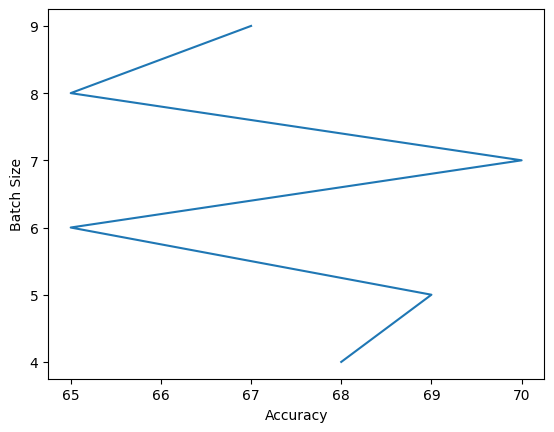

In [87]:
import matplotlib.pyplot as plt

plt.plot(batch_accuracies, batch_sizes)
plt.xlabel('Accuracy')
plt.ylabel('Batch Size')
plt.show()

In [49]:
best_batch_size = 8
print(f'Best batch size for our data: {best_batch_size}')

Best batch size for our data: 8


In [89]:
save_to_file('trained_hyperparameters.txt', batch_accuracies=batch_accuracies, batch_sizes=batch_sizes)

#### Epochs

In [ ]:
epoch_values = [10, 15, 20, 30]
best_accuracy = float('-inf')
best_model = None
best_epoch_size = -1
epoch_accuracies = []

print('\n-------- Identifying the best epoch ----------')
for epoch in epoch_values:
    print(f'Trying epoch value: {epoch}')
    net = DynamicCNN(opt_conv_layers, opt_conv_channels, opt_fc_layers, opt_fc_units, dropout_rate)
    model, accuracy = kfold_cross_validation(trainset, net, best_batch_size, epoch, best_lr, best_momentum)
    epoch_accuracies.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_epoch_size = epoch

The train accuracy is relatively higher compared to the validation/test accuracy. Looks like the model might be overfitting on the training set as we increase the number of epochs. 
What can we do now?
- It might be a good idea to add a regularization term to the loss?
    Edit: Added L2 regularization but still seems to overfit!
- Maybe the network is too complex for our data?

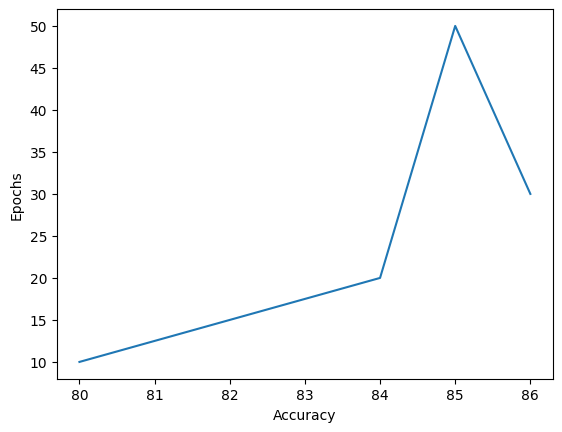

In [43]:
import matplotlib.pyplot as plt

plt.plot(epoch_accuracies, epoch_values)
plt.xlabel('Accuracy')
plt.ylabel('Epochs')
plt.show()

In [50]:
best_epoch_size = 40
print(f'Best epoch for our data: {best_epoch_size}')

Best epoch for our data: 40


### Saving our model

In [51]:
net = DynamicCNN(opt_conv_layers, opt_conv_channels, opt_fc_layers, opt_fc_units, dropout_rate)
model, accuracy = kfold_cross_validation(trainset, net, best_batch_size, best_epoch_size, best_lr, best_momentum, weight_decay=0.0002)


------------ FOLD 1 --------------
Created validation set
Created train set

XXXXXXXX Beginning model training XXXXXXXXXX
Epoch: 1 loss: 1.976


Epoch: 2 loss: 1.736
Epoch: 3 loss: 1.643
Epoch: 4 loss: 1.584
Epoch: 5 loss: 1.528
Epoch: 6 loss: 1.491
Epoch: 7 loss: 1.465
Epoch: 8 loss: 1.445
Epoch: 9 loss: 1.413
Epoch: 10 loss: 1.403
Epoch: 11 loss: 1.385
Epoch: 12 loss: 1.385
Epoch: 13 loss: 1.357
Epoch: 14 loss: 1.350
Epoch: 15 loss: 1.335
Epoch: 16 loss: 1.336
Epoch: 17 loss: 1.328
Epoch: 18 loss: 1.322
Epoch: 19 loss: 1.306
Epoch: 20 loss: 1.299
Epoch: 21 loss: 1.293
Epoch: 22 loss: 1.284
Epoch: 23 loss: 1.272
Epoch: 24 loss: 1.284
Epoch: 25 loss: 1.283
Epoch: 26 loss: 1.263
Epoch: 27 loss: 1.267
Epoch: 28 loss: 1.256
Epoch: 29 loss: 1.262
Epoch: 30 loss: 1.262
Epoch: 31 loss: 1.248
Epoch: 32 loss: 1.244
Epoch: 33 loss: 1.241
Epoch: 34 loss: 1.233
Epoch: 35 loss: 1.241
Epoch: 36 loss: 1.229
Epoch: 37 loss: 1.232
Epoch: 38 loss: 1.231
Epoch: 39 loss: 1.228
Epoch: 40 loss: 1.220
XXXXXXXX Finished Training XXXXXXXXX

XXXXXXX Testing the model XXXXXX
Accuracy of the network on the train set: 60 %
Accuracy of the network on the v

In [ ]:
print('SAVING BEST MODEL to ./cifar_net.pth')
torch.save(model.state_dict(), 'cifar_net.pth')

SAVING BEST MODEL to ./cifar_net.pth


RuntimeError: Parent directory storage/prashanthj/projects does not exist.

In [34]:
accuracy_score = test_accuracy(testloader, model)
accuracy_score

57